In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.stats import norm, ttest_ind_from_stats, t

In [2]:
df = pd.read_csv('stats.txt', sep=',')
df.head()

,problem_name,planning_time,plan_length
0,problems/problem-experiment_5x5_6_150_1/proble...,0.647604,13
1,problems/problem-experiment_5x5_6_150_1/proble...,0.819740,30
2,problems/problem-experiment_5x5_6_150_1/proble...,0.737229,24
3,problems/problem-experiment_5x5_6_150_1/proble...,0.633495,16
4,problems/problem-experiment_5x5_6_150_1/proble...,0.642722,9


In [3]:
df['is_subproblem'] = df['problem_name'].str.split('/').str.len() > 2
df['problem'] = df['problem_name'].str.split('/').str[-1]
df['size'] = df['problem'].str.split('_').str[1].str.split('x').str[0].astype(int)
df['keys_count'] = df['problem'].str.split('_').str[2].astype(int)

In [4]:
df_subproblems = df[df['is_subproblem']].copy()

df_subproblems['subproblem_part'] = df_subproblems['problem'].str.split('-').str[-1]
df_subproblems['problem'] = df_subproblems['problem'].str.split('-').str[:-1].str.join('-') + '.pddl'

df_subproblems_collected = df_subproblems.groupby(by=['problem', 'size', 'keys_count'])[['planning_time', 'plan_length']].sum().reset_index()

df_subproblems_collected['is_subproblem'] = True
df_subproblems_collected['problem_base_name'] = df_subproblems_collected['problem'].str.split('-').str[1]
df['problem_base_name'] = df['problem'].str.split('-').str[1].str.split('.').str[0]
df_subproblems_collected

,problem,size,keys_count,planning_time,plan_length,is_subproblem,problem_base_name
0,problem-experiment_5x5_6_150_1-subproblem.pddl,5,6,4.045366,96,True,experiment_5x5_6_150_1
1,problem-experiment_5x5_6_150_10-subproblem.pddl,5,6,4.656749,117,True,experiment_5x5_6_150_10
2,problem-experiment_5x5_6_150_11-subproblem.pddl,5,6,5.267095,98,True,experiment_5x5_6_150_11
3,problem-experiment_5x5_6_150_12-subproblem.pddl,5,6,27.664770,129,True,experiment_5x5_6_150_12
4,problem-experiment_5x5_6_150_13-subproblem.pddl,5,6,5.080721,158,True,experiment_5x5_6_150_13
...,...,...,...,...,...,...,...
295,problem-experiment_7x7_6_150_6-subproblem.pddl,7,6,244.312817,404,True,experiment_7x7_6_150_6
296,problem-experiment_7x7_6_150_60-subproblem.pddl,7,6,14.618793,167,True,experiment_7x7_6_150_60
297,problem-experiment_7x7_6_150_7-subproblem.pddl,7,6,64.536248,109,True,experiment_7x7_6_150_7
298,problem-experiment_7x7_6_150_8-subproblem.pddl,7,6,96.147081,284,True,experiment_7x7_6_150_8


In [5]:
df_collected = pd.concat([df[~df['is_subproblem']], df_subproblems_collected], axis='rows')
df_collected['time_out'] = (df_collected['plan_length'] == -1).astype(float)

df_collected

,problem_name,planning_time,plan_length,is_subproblem,problem,size,keys_count,problem_base_name,time_out
6,problems/problem-experiment_5x5_6_150_1.pddl,1.543421,168,False,problem-experiment_5x5_6_150_1.pddl,5,6,experiment_5x5_6_150_1,0.0
13,problems/problem-experiment_5x5_6_150_2.pddl,2.186317,136,False,problem-experiment_5x5_6_150_2.pddl,5,6,experiment_5x5_6_150_2,0.0
20,problems/problem-experiment_5x5_6_150_3.pddl,4.404218,318,False,problem-experiment_5x5_6_150_3.pddl,5,6,experiment_5x5_6_150_3,0.0
27,problems/problem-experiment_5x5_6_150_4.pddl,3.257369,210,False,problem-experiment_5x5_6_150_4.pddl,5,6,experiment_5x5_6_150_4,0.0
34,problems/problem-experiment_5x5_6_150_5.pddl,3.866662,280,False,problem-experiment_5x5_6_150_5.pddl,5,6,experiment_5x5_6_150_5,0.0
...,...,...,...,...,...,...,...,...,...
295,NaN,244.312817,404,True,problem-experiment_7x7_6_150_6-subproblem.pddl,7,6,experiment_7x7_6_150_6,0.0
296,NaN,14.618793,167,True,problem-experiment_7x7_6_150_60-subproblem.pddl,7,6,experiment_7x7_6_150_60,0.0
297,NaN,64.536248,109,True,problem-experiment_7x7_6_150_7-subproblem.pddl,7,6,experiment_7x7_6_150_7,0.0
298,NaN,96.147081,284,True,problem-experiment_7x7_6_150_8-subproblem.pddl,7,6,experiment_7x7_6_150_8,0.0


In [6]:
df_grouped = df_collected.groupby(by=['size', 'keys_count', 'is_subproblem'])[['planning_time', 'time_out']]

df_means = df_grouped.mean().reset_index()
df_counts = df_grouped.count().reset_index()
df_std = df_grouped.std().reset_index()

df_joined = pd.merge(pd.merge(df_std, df_counts, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('_std', '_count')), df_means, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('', '_mean'))

df_joined['std_avg'] = df_joined['planning_time_std'] / np.sqrt(df_joined['planning_time_count'])
df_joined['time_out_std_avg'] = df_joined['time_out_std'] / np.sqrt(df_joined['time_out_count'])
df_joined

,size,keys_count,is_subproblem,planning_time_std,time_out_std,planning_time_count,time_out_count,planning_time,time_out,std_avg,time_out_std_avg
0,5,6,False,159.095700,0.266747,40,40,49.981326,0.075,25.155239,0.042176
1,5,6,True,4.566694,0.000000,40,40,6.895508,0.000,0.722058,0.000000
2,6,5,False,203.467214,0.334932,40,40,112.755207,0.125,32.170991,0.052957
3,6,5,True,10.714820,0.000000,40,40,12.709083,0.000,1.694162,0.000000
4,6,6,False,160.138780,0.303822,40,40,87.079452,0.100,25.320164,0.048038
5,6,6,True,6.624985,0.000000,40,40,13.351511,0.000,1.047502,0.000000
6,6,7,False,226.684408,0.405096,40,40,169.256621,0.200,35.841952,0.064051
7,6,7,True,14.607326,0.000000,40,40,18.186981,0.000,2.309621,0.000000
8,6,8,False,231.836895,0.361620,40,40,162.026221,0.150,36.656632,0.057177
9,6,8,True,8.884772,0.000000,40,40,20.346925,0.000,1.404806,0.000000


In [7]:
df_grouped_filtered = df_collected[df_collected['plan_length'] != -1].groupby(by=['size', 'keys_count', 'is_subproblem'])[['planning_time', 'time_out', 'plan_length']]

df_means_filtered = df_grouped_filtered.mean().reset_index()
df_counts_filtered = df_grouped_filtered.count().reset_index()
df_std_filtered = df_grouped_filtered.std().reset_index()

df_joined_filtered = pd.merge(pd.merge(df_std_filtered, df_counts_filtered, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('_std', '_count')), df_means_filtered, on=['size', 'keys_count', 'is_subproblem'], how='inner', suffixes=('', '_mean'))

df_joined_filtered['std_avg'] = df_joined_filtered['planning_time_std'] / np.sqrt(df_joined_filtered['planning_time_count'])
df_joined_filtered['time_out_std_avg'] = df_joined_filtered['time_out_std'] / np.sqrt(df_joined_filtered['time_out_count'])
df_joined_filtered['plan_length_std_avg'] = df_joined_filtered['plan_length_std'] / np.sqrt(df_joined_filtered['plan_length_count'])

df_joined_filtered

,size,keys_count,is_subproblem,planning_time_std,time_out_std,plan_length_std,planning_time_count,time_out_count,plan_length_count,planning_time,time_out,plan_length,std_avg,time_out_std_avg,plan_length_std_avg
0,5,6,False,7.086384,0.0,92.839346,37,37,37,5.290085,0.0,228.459459,1.164994,0.0,15.262694
1,5,6,True,4.566694,0.0,41.672341,40,40,40,6.895508,0.0,130.075000,0.722058,0.0,6.588976
2,6,5,False,85.802062,0.0,87.300890,35,35,35,42.953206,0.0,221.714286,14.503196,0.0,14.756544
3,6,5,True,10.714820,0.0,56.708380,40,40,40,12.709083,0.0,131.175000,1.694162,0.0,8.966382
4,6,6,False,45.954599,0.0,135.654682,36,36,36,38.242149,0.0,294.583333,7.659100,0.0,22.609114
5,6,6,True,6.624985,0.0,59.747675,40,40,40,13.351511,0.0,161.100000,1.047502,0.0,9.446937
6,6,7,False,65.711087,0.0,160.305542,32,32,32,61.142391,0.0,378.437500,11.616189,0.0,28.338284
7,6,7,True,14.607326,0.0,74.211669,40,40,40,18.186981,0.0,194.250000,2.309621,0.0,11.733895
8,6,8,False,148.954941,0.0,160.267604,34,34,34,84.452859,0.0,392.852941,25.545562,0.0,27.485667
9,6,8,True,8.884772,0.0,61.720083,40,40,40,20.346925,0.0,228.625000,1.404806,0.0,9.758802


In [8]:
df_collected_changed = df_collected.copy()
df_collected_changed.loc[df_collected_changed['is_subproblem'], ['planning_time', 'plan_length']] *= -1

df_differenes_first = df_collected_changed.groupby(by='problem_base_name')[['plan_length', 'planning_time']].sum()
df_are_all = df_collected.groupby(by='problem_base_name')[['plan_length']].min() != -1
df_differenes_first_correct = df_differenes_first[df_are_all['plan_length']].copy()

df_differenes_first_correct['size'] = df_differenes_first_correct.index.str.split('_').str[1].str.split('x').str[0].astype(int)
df_differenes_first_correct['keys_count'] = df_differenes_first_correct.index.str.split('_').str[2].astype(int)

df_differenes_first_correct

,plan_length,planning_time,size,keys_count
problem_base_name,,,,
experiment_5x5_6_150_1,72,-2.501945,5,6
experiment_5x5_6_150_10,166,-0.737137,5,6
experiment_5x5_6_150_11,338,10.451358,5,6
experiment_5x5_6_150_12,228,-18.011858,5,6
experiment_5x5_6_150_13,134,1.497018,5,6
...,...,...,...,...
experiment_7x7_6_150_56,233,20.358738,7,6
experiment_7x7_6_150_57,128,8.233264,7,6
experiment_7x7_6_150_60,243,148.671109,7,6


In [9]:
df_differences_first_correct_aggregated_means = df_differenes_first_correct.groupby(by=['size', 'keys_count'])[['plan_length', 'planning_time']].mean().reset_index()
df_differences_first_correct_aggregated_std = df_differenes_first_correct.groupby(by=['size', 'keys_count'])[['plan_length', 'planning_time']].std().reset_index()
df_differences_first_correct_aggregated_counts = df_differenes_first_correct.groupby(by=['size', 'keys_count'])[['plan_length', 'planning_time']].count().reset_index()

df_differences_first_correct_aggregated = pd.merge(df_differences_first_correct_aggregated_means, df_differences_first_correct_aggregated_std, on=['size', 'keys_count'], how='inner', suffixes=('_mean', '_std'))

df_differences_first_correct_aggregated['count'] = df_differences_first_correct_aggregated_counts['planning_time']

df_differences_first_correct_aggregated['planning_time_avg_std'] = df_differences_first_correct_aggregated['planning_time_std'] / np.sqrt(df_differences_first_correct_aggregated['count'])
df_differences_first_correct_aggregated['plan_length_avg_std'] = df_differences_first_correct_aggregated['plan_length_std'] / np.sqrt(df_differences_first_correct_aggregated['count'])

df_differences_first_correct_aggregated['planning_time_z_value'] = df_differences_first_correct_aggregated['planning_time_mean'] / df_differences_first_correct_aggregated['planning_time_avg_std']
df_differences_first_correct_aggregated['plan_length_z_value'] = df_differences_first_correct_aggregated['plan_length_mean'] / df_differences_first_correct_aggregated['plan_length_avg_std']

df_differences_first_correct_aggregated['planning_time_p_value'] = 1.0 - norm.cdf(df_differences_first_correct_aggregated['planning_time_z_value'])
df_differences_first_correct_aggregated['plan_length_p_value'] = 1.0 - norm.cdf(df_differences_first_correct_aggregated['plan_length_z_value'])

df_differences_first_correct_aggregated

,size,keys_count,plan_length_mean,planning_time_mean,plan_length_std,planning_time_std,count,planning_time_avg_std,plan_length_avg_std,planning_time_z_value,plan_length_z_value,planning_time_p_value,plan_length_p_value
0,5,6,100.405405,-1.317004,94.756254,7.903069,37,1.299257,15.577832,-1.013660,6.445403,0.844627,5.764689e-11
1,6,5,87.942857,29.678958,99.898167,84.291393,35,14.247846,16.885872,2.083049,5.208073,0.018623,9.540585e-08
2,6,6,138.222222,24.985491,135.692112,46.510114,36,7.751686,22.615352,3.223233,6.111876,0.000634,4.923341e-10
3,6,7,188.312500,44.083103,182.977072,69.825345,32,12.343494,32.346082,3.571364,5.821802,0.000178,2.910817e-09
4,6,8,155.794118,64.171625,154.808147,149.624144,34,25.660329,26.549378,2.500811,5.868089,0.006195,2.204231e-09
5,6,9,81.354839,-0.863496,205.910425,115.725387,31,20.784893,36.982604,-0.041544,2.199814,0.516569,1.391006e-02
6,7,6,158.666667,75.434494,173.125718,116.700414,36,19.450069,28.854286,3.878366,5.498894,0.000053,1.910902e-08


In [10]:
df_means_size6_all = df_joined[df_joined['size'] == 6]
df_means_keys6_all = df_joined[df_joined['keys_count'] == 6]

df_means_size6_subproblems_all = df_means_size6_all[df_means_size6_all['is_subproblem']]
df_means_size6_full_problems_all = df_means_size6_all[~df_means_size6_all['is_subproblem']]

df_means_keys6_subproblems_all = df_means_keys6_all[df_means_keys6_all['is_subproblem']]
df_means_keys6_full_problems_all = df_means_keys6_all[~df_means_keys6_all['is_subproblem']]

In [11]:
df_means_size6 = df_joined_filtered[df_joined_filtered['size'] == 6] # filtered now
df_means_keys6 = df_joined_filtered[df_joined_filtered['keys_count'] == 6]

df_means_size6_subproblems = df_means_size6[df_means_size6['is_subproblem']]
df_means_size6_full_problems = df_means_size6[~df_means_size6['is_subproblem']]

df_means_keys6_subproblems = df_means_keys6[df_means_keys6['is_subproblem']]
df_means_keys6_full_problems = df_means_keys6[~df_means_keys6['is_subproblem']]

In [12]:
df_means_size6_filtered = df_joined_filtered[df_joined_filtered['size'] == 6]
df_means_keys6_filtered = df_joined_filtered[df_joined_filtered['keys_count'] == 6]

df_means_size6_subproblems_filtered = df_means_size6_filtered[df_means_size6_filtered['is_subproblem']]
df_means_size6_full_problems_filtered = df_means_size6_filtered[~df_means_size6_filtered['is_subproblem']]

df_means_keys6_subproblems_filtered = df_means_keys6_filtered[df_means_keys6_filtered['is_subproblem']]
df_means_keys6_full_problems_filtered = df_means_keys6_filtered[~df_means_keys6_filtered['is_subproblem']]

In [13]:
df_differences = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['planning_time', 'std_avg']).apply(
    lambda row: [
        row['planning_time'][False] - row['planning_time'][True],
        np.sqrt(row['std_avg'][False] ** 2 + row['std_avg'][True] ** 2)
    ], axis=1).reset_index(name='difference_with_std')
df_differences[['difference', 'std']] = df_differences['difference_with_std'].apply(pd.Series)

df_differences

,size,keys_count,difference_with_std,difference,std
0,5,6,"[-1.605422660980011, 1.3706127269431567]",-1.605423,1.370613
1,6,5,"[30.244123105754156, 14.6018104104712]",30.244123,14.601810
2,6,6,"[24.89063792332707, 7.730399181458555]",24.890638,7.730399
3,6,7,"[42.95541033510044, 11.843571753592473]",42.955410,11.843572
4,6,8,"[64.10593351285054, 25.58415910726101]",64.105934,25.584159
5,6,9,"[3.930628733936153, 16.919495210026533]",3.930629,16.919495
6,7,6,"[73.45939333889967, 20.067641550006]",73.459393,20.067642


In [14]:
df_differences_filtered = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['plan_length', 'plan_length_std_avg']).apply(
    lambda row: [
        row['plan_length'][False] - row['plan_length'][True],
        np.sqrt(row['plan_length_std_avg'][False] ** 2 + row['plan_length_std_avg'][True] ** 2)
    ], axis=1).reset_index(name='difference_with_std')
df_differences_filtered[['difference', 'std']] = df_differences_filtered['difference_with_std'].apply(pd.Series)

df_differences_filtered

,size,keys_count,difference_with_std,difference,std
0,5,6,"[98.38445945945946, 16.624212495411623]",98.384459,16.624212
1,6,5,"[90.53928571428571, 17.2670666833796]",90.539286,17.267067
2,6,6,"[133.48333333333332, 24.503400563883766]",133.483333,24.503401
3,6,7,"[184.1875, 30.67152811005128]",184.187500,30.671528
4,6,8,"[164.2279411764706, 29.16669549753895]",164.227941,29.166695
5,6,9,"[80.8306451612903, 35.60906864219127]",80.830645,35.609069
6,7,6,"[150.42777777777778, 28.740435026651546]",150.427778,28.740435


In [15]:
different_times_pvalues = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['planning_time', 'std_avg', 'planning_time_std', 'planning_time_count']).apply(
    lambda row:
        # 1.0 - norm.cdf((row['planning_time'][False] - row['planning_time'][True]) / np.sqrt(row['std_avg'][False] ** 2 + row['std_avg'][True] ** 2)), axis=1).reset_index(name='p_value')
           ttest_ind_from_stats(row['planning_time'][False], row['planning_time_std'][False], row['planning_time_count'][False],
                                row['planning_time'][True], row['planning_time_std'][True], row['planning_time_count'][True],
                                equal_var=False).pvalue, axis=1).reset_index(name='p_value')

different_times_pvalues

,size,keys_count,p_value
0,5,6,0.246048
1,6,5,0.045786
2,6,6,0.002703
3,6,7,0.000944
4,6,8,0.017300
5,6,9,0.816985
6,7,6,0.000707


In [16]:
different_lengths_pvalues_filtered = df_joined_filtered.pivot(index=['size', 'keys_count'], columns='is_subproblem', values=['plan_length', 'plan_length_std_avg', 'plan_length_std', 'plan_length_count']).apply(
    lambda row:
        # 1.0 - norm.cdf((row['plan_length'][False] - row['plan_length'][True]) / np.sqrt(row['plan_length_std_avg'][False] ** 2 + row['plan_length_std_avg'][True] ** 2)), axis=1).reset_index(name='p_value')
              ttest_ind_from_stats(row['plan_length'][False], row['plan_length_std'][False], row['plan_length_count'][False],
                                  row['plan_length'][True], row['plan_length_std'][True], row['plan_length_count'][True],
                                  equal_var=False).pvalue, axis=1).reset_index(name='p_value')

different_lengths_pvalues_filtered

,size,keys_count,p_value
0,5,6,3.108890e-07
1,6,5,2.399551e-06
2,6,6,1.825599e-06
3,6,7,4.049901e-07
4,6,8,1.418276e-06
5,6,9,2.792701e-02
6,7,6,3.959541e-06


In [17]:
certainty_level_error = 0.05

In [18]:
z_value_max_value = norm.ppf(1.0 - certainty_level_error)

In [19]:
x_ticks_size6 = df_means_size6_full_problems['keys_count']
x_ticks_keys6 = df_means_keys6_full_problems['size']

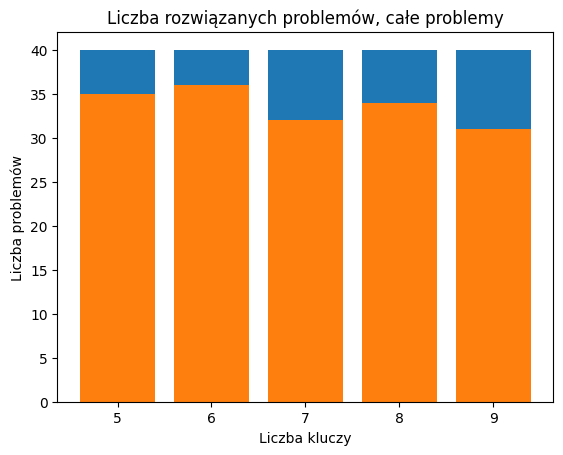

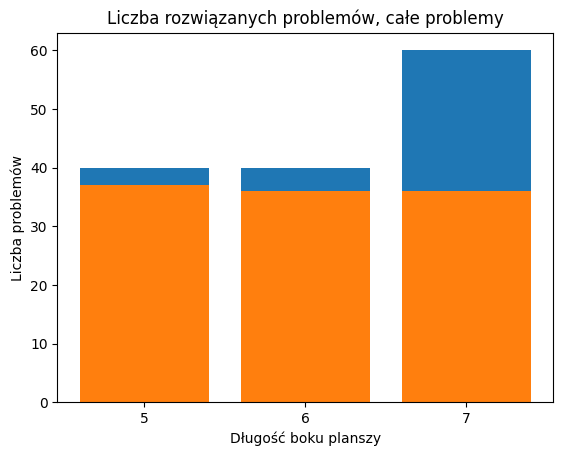

In [20]:
plt.xticks(x_ticks_size6)
plt.title("Liczba rozwiązanych problemów, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Liczba problemów')
plt.bar(df_means_size6_full_problems_all['keys_count'], df_means_size6_full_problems_all['time_out_count'])
plt.bar(df_means_size6_full_problems['keys_count'], df_means_size6_full_problems['time_out_count'])
plt.savefig('plots/solved_count_full_problems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Liczba rozwiązanych problemów, całe problemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Liczba problemów')
plt.bar(df_means_keys6_full_problems_all['size'], df_means_keys6_full_problems_all['time_out_count'])
plt.bar(df_means_keys6_full_problems['size'], df_means_keys6_full_problems['time_out_count'])
plt.savefig('plots/solved_count_size_full_problems.png')
plt.show()

In [21]:
differences_correct_selected_size6 = df_differences_first_correct_aggregated[df_differences_first_correct_aggregated['size'] == 6]
differences_correct_selected_size6

,size,keys_count,plan_length_mean,planning_time_mean,plan_length_std,planning_time_std,count,planning_time_avg_std,plan_length_avg_std,planning_time_z_value,plan_length_z_value,planning_time_p_value,plan_length_p_value
1,6,5,87.942857,29.678958,99.898167,84.291393,35,14.247846,16.885872,2.083049,5.208073,0.018623,9.540585e-08
2,6,6,138.222222,24.985491,135.692112,46.510114,36,7.751686,22.615352,3.223233,6.111876,0.000634,4.923341e-10
3,6,7,188.312500,44.083103,182.977072,69.825345,32,12.343494,32.346082,3.571364,5.821802,0.000178,2.910817e-09
4,6,8,155.794118,64.171625,154.808147,149.624144,34,25.660329,26.549378,2.500811,5.868089,0.006195,2.204231e-09
5,6,9,81.354839,-0.863496,205.910425,115.725387,31,20.784893,36.982604,-0.041544,2.199814,0.516569,1.391006e-02


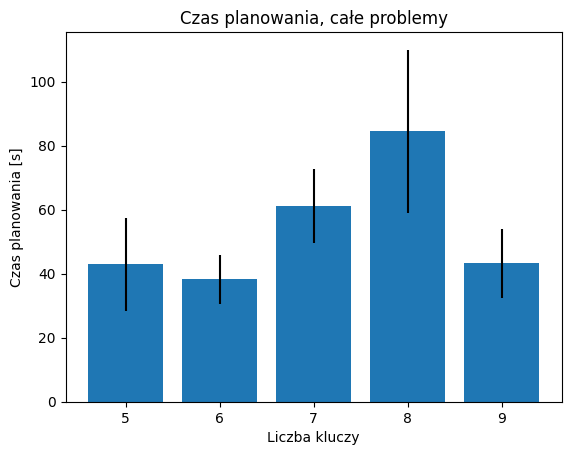

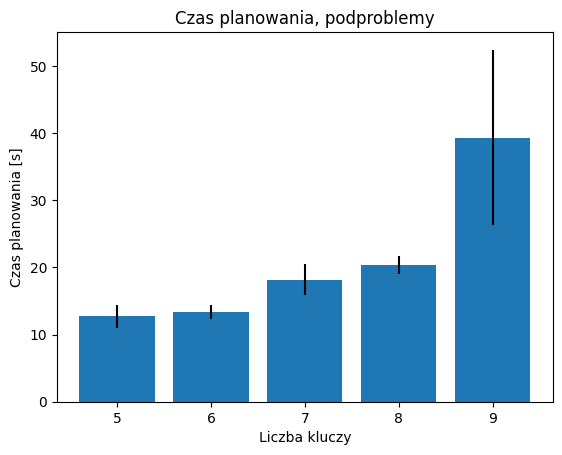

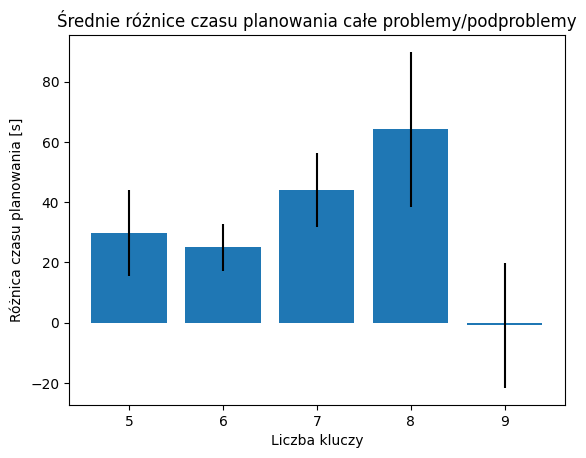

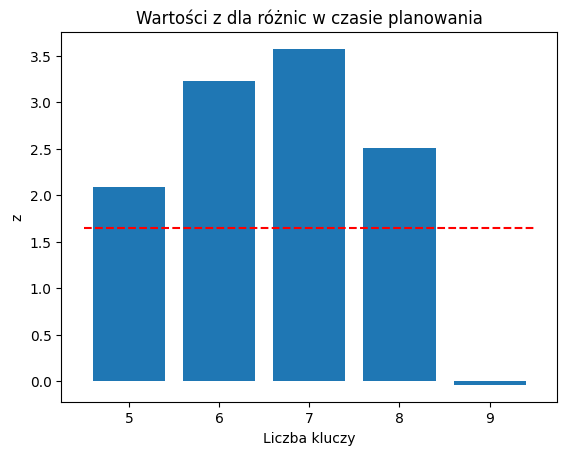

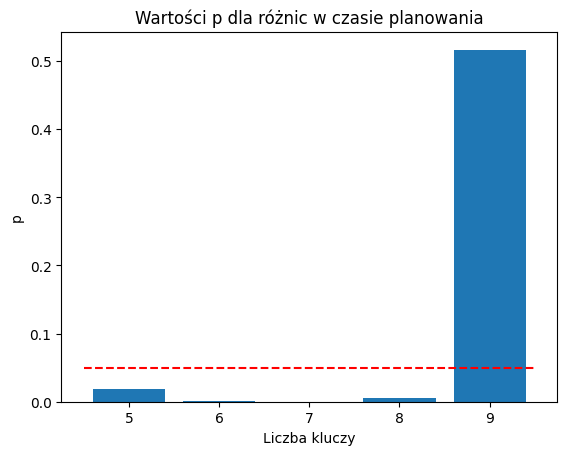

In [22]:
plt.xticks(x_ticks_size6)
plt.title("Czas planowania, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_size6_full_problems['keys_count'], df_means_size6_full_problems['planning_time'], yerr=df_means_size6_full_problems['std_avg'])
plt.savefig('plots/planning_time_full_problems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Czas planowania, podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_size6_subproblems['keys_count'], df_means_size6_subproblems['planning_time'],
        yerr=df_means_size6_subproblems['std_avg'])
plt.savefig('plots/planning_time_subproblems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Średnie różnice czasu planowania całe problemy/podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Różnica czasu planowania [s]')
plt.bar(differences_correct_selected_size6['keys_count'], differences_correct_selected_size6['planning_time_mean'], yerr=differences_correct_selected_size6['planning_time_avg_std'])
plt.savefig('plots/planning_time_differences.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Wartości z dla różnic w czasie planowania")
plt.xlabel('Liczba kluczy')
plt.ylabel('z')
plt.bar(differences_correct_selected_size6['keys_count'], differences_correct_selected_size6['planning_time_z_value'])
plt.plot([min(differences_correct_selected_size6['keys_count']) - 0.5,
            max(differences_correct_selected_size6['keys_count']) + 0.5], [z_value_max_value, z_value_max_value], 'r--')
plt.savefig('plots/planning_time_z_values.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Wartości p dla różnic w czasie planowania")
plt.xlabel('Liczba kluczy')
plt.ylabel('p')
plt.bar(differences_correct_selected_size6['keys_count'], differences_correct_selected_size6['planning_time_p_value'])
plt.plot([min(differences_correct_selected_size6['keys_count']) - 0.5,
            max(differences_correct_selected_size6['keys_count']) + 0.5], [certainty_level_error, certainty_level_error], 'r--')
plt.savefig('plots/planning_time_p_values.png')
plt.show()

In [23]:
differences_correct_selected_keys6 = df_differences_first_correct_aggregated[df_differences_first_correct_aggregated['keys_count'] == 6]

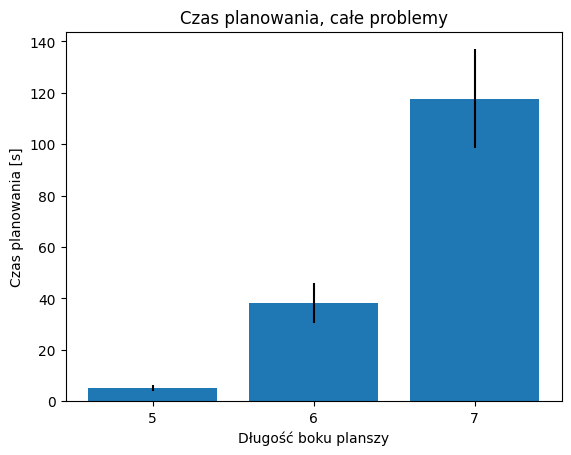

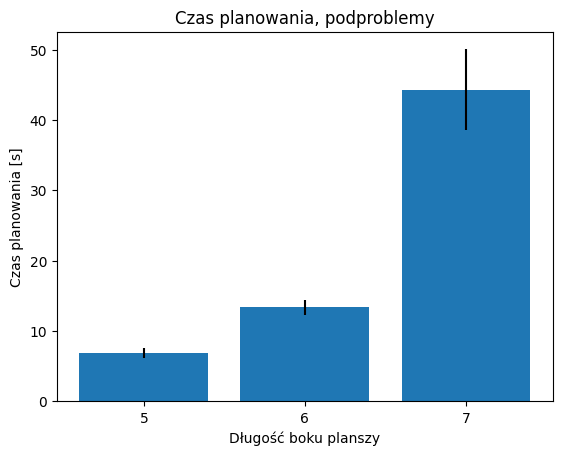

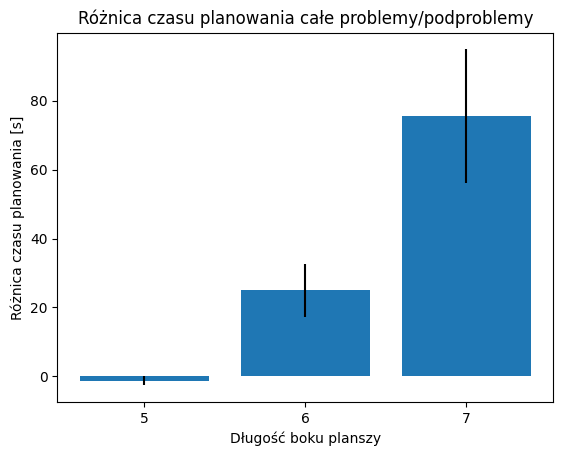

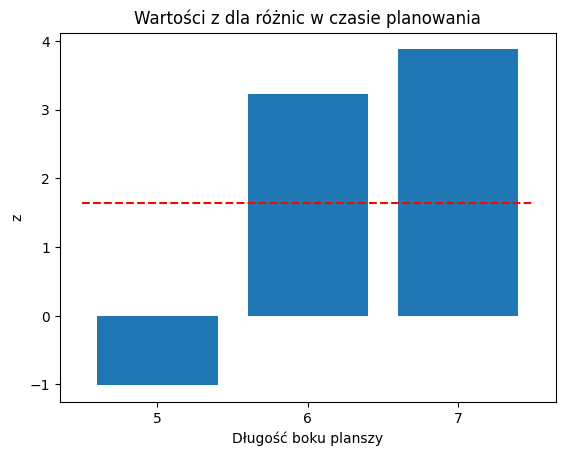

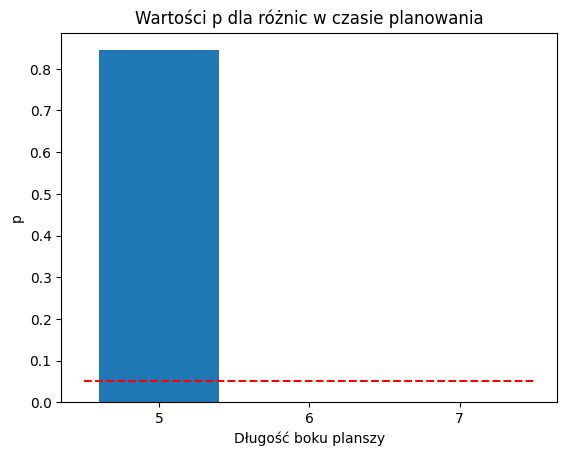

In [24]:
plt.xticks(x_ticks_keys6)
plt.title('Czas planowania, całe problemy')
plt.xlabel('Długość boku planszy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_keys6_full_problems['size'], df_means_keys6_full_problems['planning_time'], yerr=df_means_keys6_full_problems['std_avg'])
plt.savefig('plots/planning_time_size_full_problems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title('Czas planowania, podproblemy')
plt.xlabel('Długość boku planszy')
plt.ylabel('Czas planowania [s]')
plt.bar(df_means_keys6_subproblems['size'], df_means_keys6_subproblems['planning_time'], yerr=df_means_keys6_subproblems['std_avg'])
plt.savefig('plots/planning_time_size_subproblems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title('Różnica czasu planowania całe problemy/podproblemy')
plt.xlabel('Długość boku planszy')
plt.ylabel('Różnica czasu planowania [s]')
plt.bar(differences_correct_selected_keys6['size'], differences_correct_selected_keys6['planning_time_mean'], yerr=differences_correct_selected_keys6['planning_time_avg_std'])
plt.savefig('plots/planning_time_size_differences.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title('Wartości z dla różnic w czasie planowania')
plt.xlabel('Długość boku planszy')
plt.ylabel('z')
plt.bar(differences_correct_selected_keys6['size'], differences_correct_selected_keys6['planning_time_z_value'])
plt.plot([min(differences_correct_selected_keys6['size']) - 0.5,
            max(differences_correct_selected_keys6['size']) + 0.5], [z_value_max_value, z_value_max_value], 'r--')
plt.savefig('plots/planning_time_size_z_values.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Wartości p dla różnic w czasie planowania")
plt.xlabel('Długość boku planszy')
plt.ylabel('p')
plt.bar(differences_correct_selected_keys6['size'], differences_correct_selected_keys6['planning_time_p_value'])
plt.plot([min(differences_correct_selected_keys6['size']) - 0.5,
            max(differences_correct_selected_keys6['size']) + 0.5], [certainty_level_error, certainty_level_error], 'r--')
plt.savefig('plots/planning_time_size_p_values.png')
plt.show()

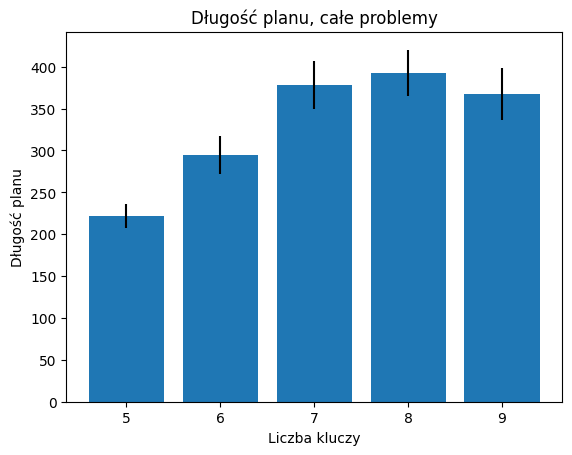

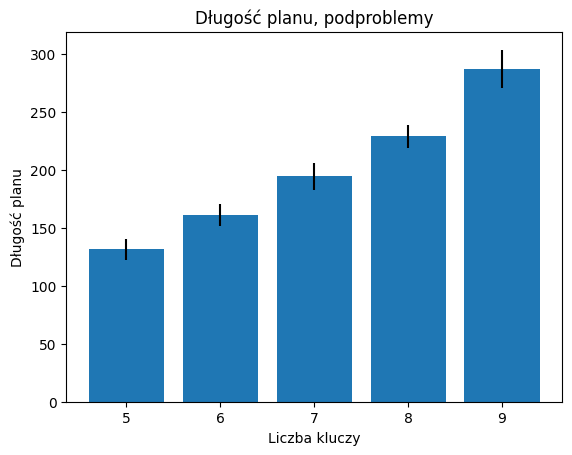

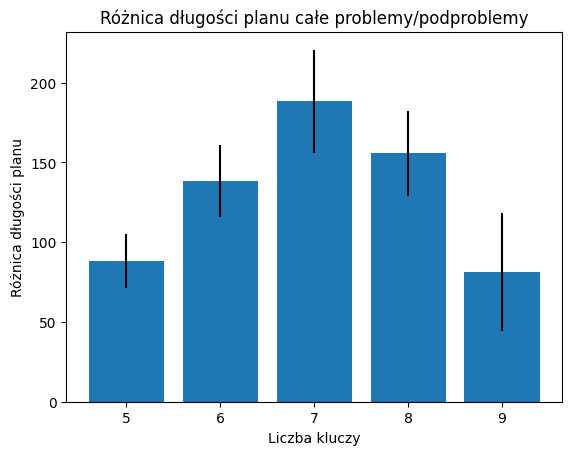

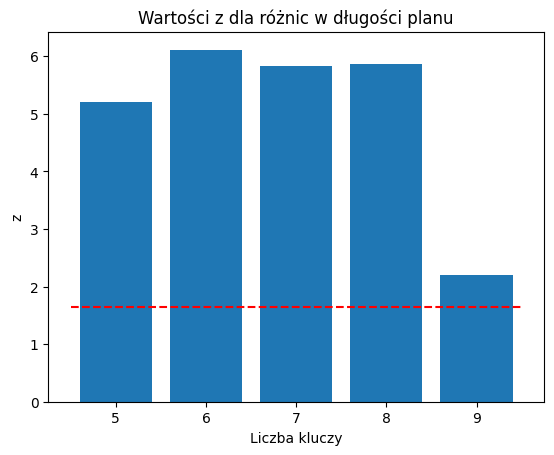

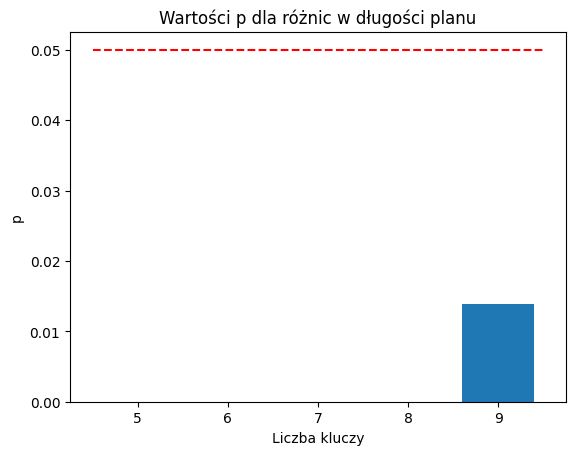

In [25]:
plt.xticks(x_ticks_size6)
plt.title("Długość planu, całe problemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Długość planu')
plt.bar(df_means_size6_full_problems_filtered['keys_count'], df_means_size6_full_problems_filtered['plan_length'], yerr=df_means_size6_full_problems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_full_problems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Długość planu, podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Długość planu')
plt.bar(df_means_size6_subproblems_filtered['keys_count'], df_means_size6_subproblems_filtered['plan_length'], yerr=df_means_size6_subproblems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_subproblems.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Różnica długości planu całe problemy/podproblemy")
plt.xlabel('Liczba kluczy')
plt.ylabel('Różnica długości planu')
plt.bar(differences_correct_selected_size6['keys_count'], differences_correct_selected_size6['plan_length_mean'], yerr=differences_correct_selected_size6['plan_length_avg_std'])
plt.savefig('plots/plan_length_differences.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Wartości z dla różnic w długości planu")
plt.xlabel('Liczba kluczy')
plt.ylabel('z')
plt.bar(differences_correct_selected_size6['keys_count'], differences_correct_selected_size6['plan_length_z_value'])
plt.plot([min(differences_correct_selected_size6['keys_count']) - 0.5, max(differences_correct_selected_size6['keys_count']) + 0.5], [z_value_max_value, z_value_max_value], 'r--')
plt.savefig('plots/plan_length_z_values.png')
plt.show()

plt.xticks(x_ticks_size6)
plt.title("Wartości p dla różnic w długości planu")
plt.xlabel('Liczba kluczy')
plt.ylabel('p')
plt.bar(differences_correct_selected_size6['keys_count'], differences_correct_selected_size6['plan_length_p_value'])
plt.plot([min(differences_correct_selected_size6['keys_count']) - 0.5, max(differences_correct_selected_size6['keys_count']) + 0.5], [certainty_level_error, certainty_level_error], 'r--')
plt.savefig('plots/plan_length_p_values.png')
plt.show()

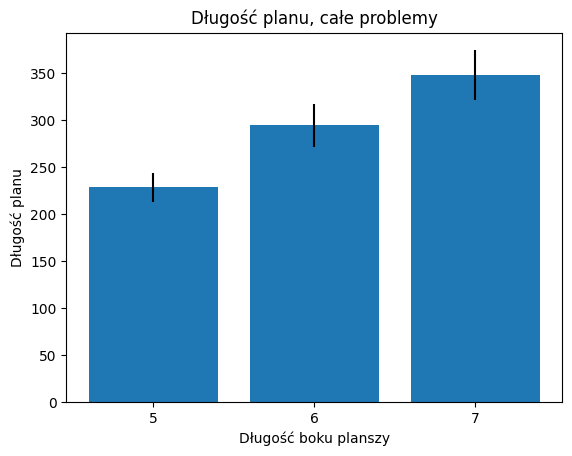

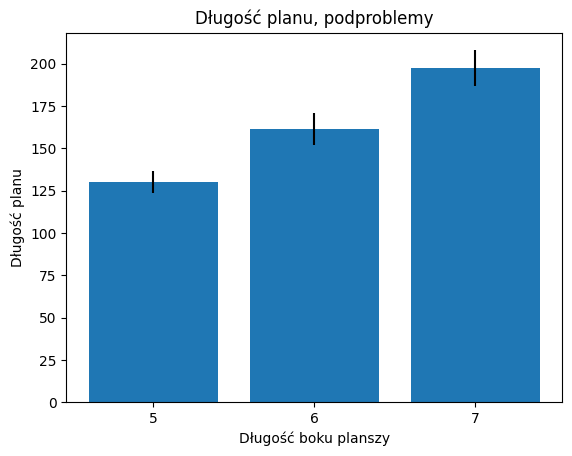

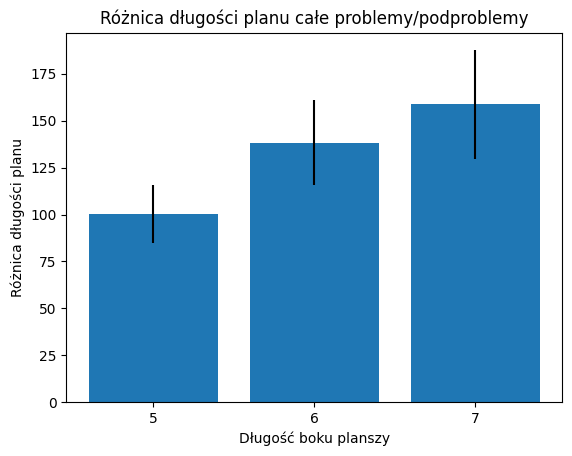

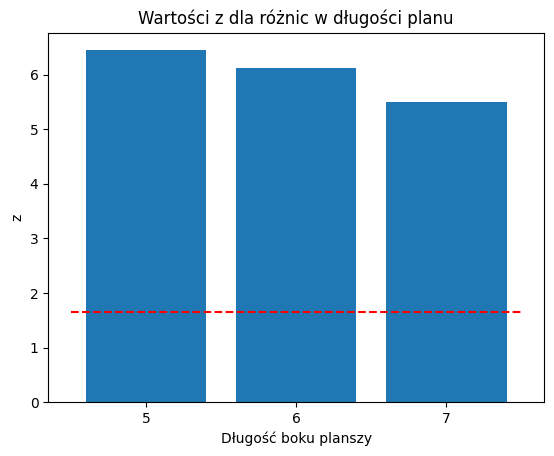

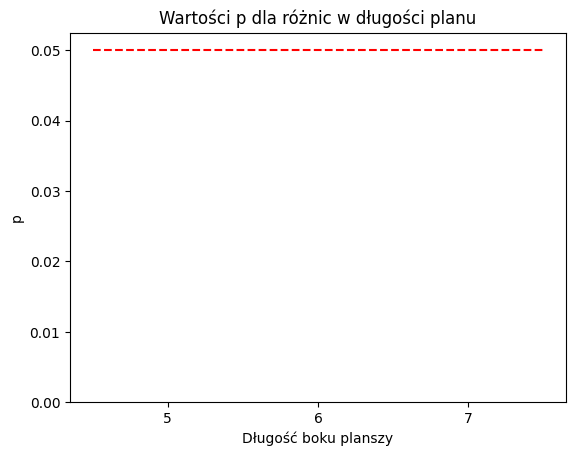

In [26]:
plt.xticks(x_ticks_keys6)
plt.title("Długość planu, całe problemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Długość planu')
plt.bar(df_means_keys6_full_problems_filtered['size'], df_means_keys6_full_problems_filtered['plan_length'], yerr=df_means_keys6_full_problems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_size_full_problems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Długość planu, podproblemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Długość planu')
plt.bar(df_means_keys6_subproblems_filtered['size'], df_means_keys6_subproblems_filtered['plan_length'], yerr=df_means_keys6_subproblems_filtered['plan_length_std_avg'])
plt.savefig('plots/plan_length_size_subproblems.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Różnica długości planu całe problemy/podproblemy")
plt.xlabel('Długość boku planszy')
plt.ylabel('Różnica długości planu')
plt.bar(differences_correct_selected_keys6['size'], differences_correct_selected_keys6['plan_length_mean'], yerr=differences_correct_selected_keys6['plan_length_avg_std'])
plt.savefig('plots/plan_length_size_differences.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Wartości z dla różnic w długości planu")
plt.xlabel('Długość boku planszy')
plt.ylabel('z')
plt.bar(differences_correct_selected_keys6['size'], differences_correct_selected_keys6['plan_length_z_value'])
plt.plot([min(differences_correct_selected_keys6['size']) - 0.5, max(differences_correct_selected_keys6['size']) + 0.5], [z_value_max_value, z_value_max_value], 'r--')
plt.savefig('plots/plan_length_size_z_values.png')
plt.show()

plt.xticks(x_ticks_keys6)
plt.title("Wartości p dla różnic w długości planu")
plt.xlabel('Długość boku planszy')
plt.ylabel('p')
plt.bar(differences_correct_selected_keys6['size'], differences_correct_selected_keys6['plan_length_p_value'])
plt.plot([min(differences_correct_selected_keys6['size']) - 0.5, max(differences_correct_selected_keys6['size']) + 0.5], [certainty_level_error, certainty_level_error], 'r--')
plt.savefig('plots/plan_length_size_p_values.png')
plt.show()

In [28]:
z_value_max_value

np.float64(1.6448536269514722)

In [30]:
df_differences_first_correct_aggregated[['size', 'keys_count', 'plan_length_mean', 'plan_length_avg_std', 'plan_length_z_value', 'plan_length_p_value']]

,size,keys_count,plan_length_mean,plan_length_avg_std,plan_length_z_value,plan_length_p_value
0,5,6,100.405405,15.577832,6.445403,5.764689e-11
1,6,5,87.942857,16.885872,5.208073,9.540585e-08
2,6,6,138.222222,22.615352,6.111876,4.923341e-10
3,6,7,188.312500,32.346082,5.821802,2.910817e-09
4,6,8,155.794118,26.549378,5.868089,2.204231e-09
5,6,9,81.354839,36.982604,2.199814,1.391006e-02
6,7,6,158.666667,28.854286,5.498894,1.910902e-08


In [31]:
df_differences_first_correct_aggregated[['size', 'keys_count', 'planning_time_mean', 'planning_time_avg_std', 'planning_time_z_value', 'planning_time_p_value']]

,size,keys_count,planning_time_mean,planning_time_avg_std,planning_time_z_value,planning_time_p_value
0,5,6,-1.317004,1.299257,-1.013660,0.844627
1,6,5,29.678958,14.247846,2.083049,0.018623
2,6,6,24.985491,7.751686,3.223233,0.000634
3,6,7,44.083103,12.343494,3.571364,0.000178
4,6,8,64.171625,25.660329,2.500811,0.006195
5,6,9,-0.863496,20.784893,-0.041544,0.516569
6,7,6,75.434494,19.450069,3.878366,0.000053
